In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("data.csv")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP


# EXPLORATORY DATA ANALYSIS


                                            - null values, outliers
                                            - variable transformation
                                            - useful variables
                                            - patterns, anomalies


## 1) Null values, outliers. Variable transformation                                           

In [3]:
# Eliminate white spaces in columns names
df.columns = df.columns.str.strip()

In [4]:
# Check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4   Income               2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

In [5]:
# Income (remove currency sign and comma)
df["Income"] = df["Income"].str.replace("$", "").str.replace(",", "").astype("float")

# Convert Dt_Customer column to datetime
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])

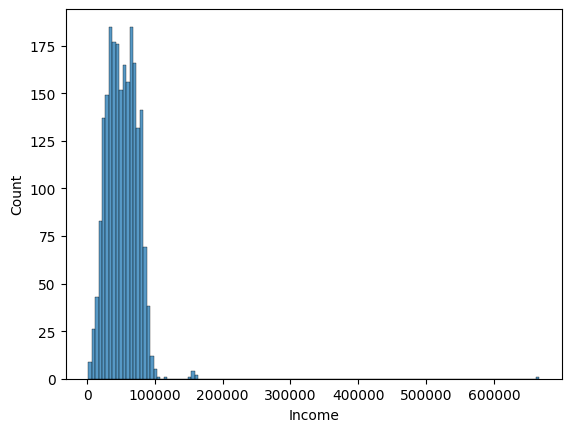

In [6]:
sns.histplot(df, x="Income")
plt.show()

We can also notice null values in the Income column.\
It follows normal distribution.\
So, we can impute empty values with the median Income value.

In [7]:
# We will impute empty values in the Income column with the median value

df.fillna({"Income": df["Income"].median()}, inplace=True)

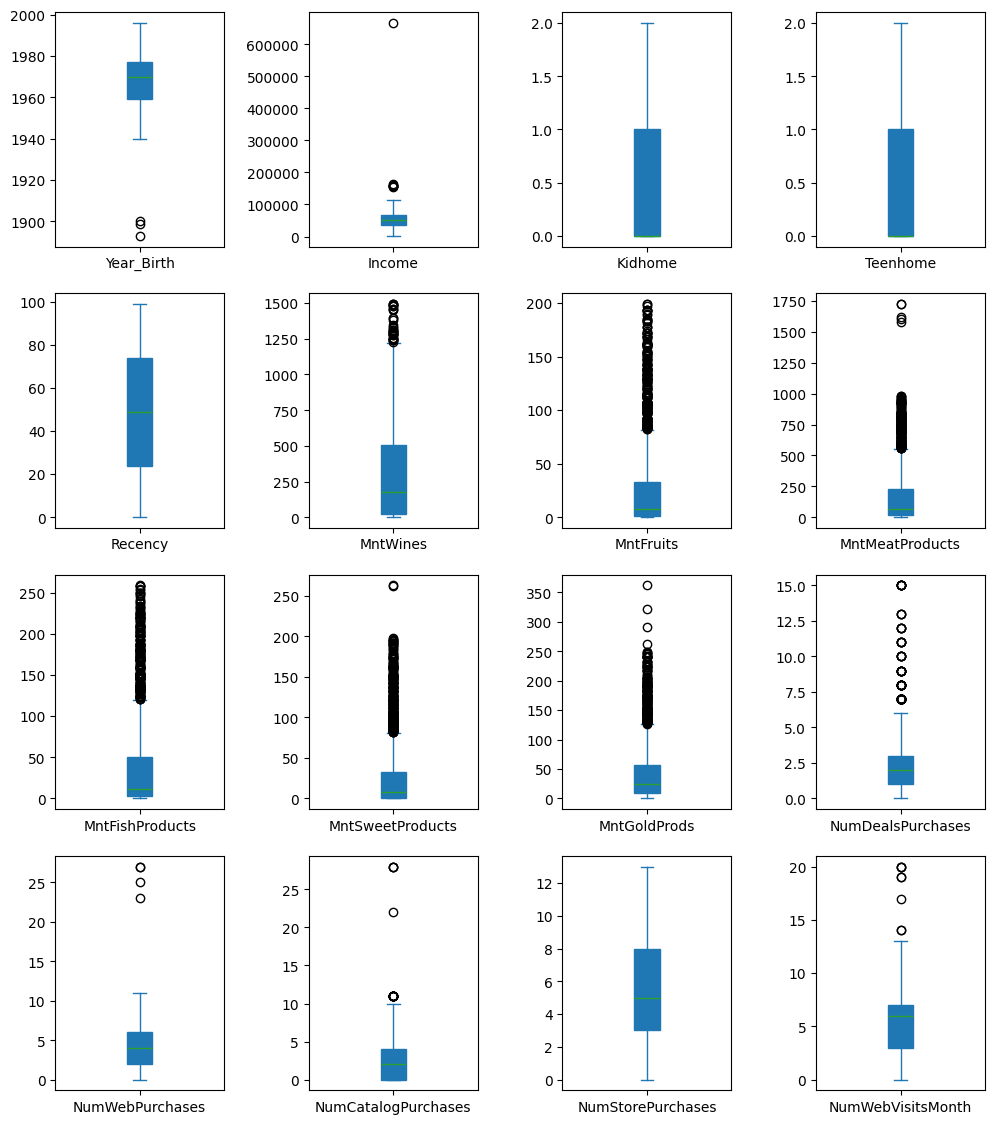

In [8]:
# Multiple features contain outliers

df_to_plot = df.drop(
    columns=['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']
)

df_to_plot.plot(
    subplots=True,
    layout=(4, 4),
    kind="box",
    figsize=(12, 14),
    patch_artist=True
)
plt.subplots_adjust(wspace=0.5)
plt.show()

The features that likely indicate data entry errors are Year_Birth <= 1900 and Income = 666666.0
Our data will not be significantly affected by removing the outliers

In [9]:
df = df.query("Year_Birth > 1900 and Income != 666666")

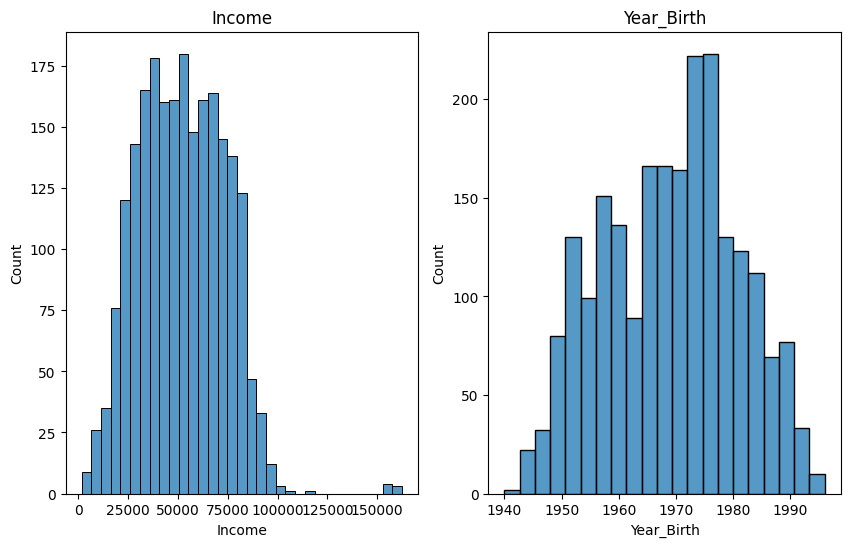

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
for i, col in enumerate(("Income", "Year_Birth")):
    sns.histplot(df, x=col, ax=ax[i])
    ax[i].set_title(col)

plt.subplots_adjust()
plt.show()

## 2) Useful variables

Here's a list of useful variables we can engineer with our data:
 - total number of dependents
 - the year of becoming a customer
 - total amount spent (Mnt columns)
 - total purchases (Purchases column)
 - total number of campaigns accepted

In [11]:
# Dependents
df["Dependents"] = df["Kidhome"] + df["Teenhome"]

# Year of becoming a customer
df["Year_Customer"] = df["Dt_Customer"].dt.year
df.drop(["Dt_Customer"], axis=1, inplace=True)

# Total amount spent
mnt_cols = [col for col in df.columns if col.startswith("Mnt")]
df["TotalMnt"] = df[mnt_cols].sum(axis=1)

# Total purchases
purchase_cols = [col for col in df.columns if col.endswith("Purchases")]
df["TotalPurchases"] = df[purchase_cols].sum(axis=1)

# Total campaigns accepted
campaign_cols = [col for col in df.columns if col.startswith("AcceptedCmp") or col == "Response"]
df["TotalCampaignsAcc"] = df[campaign_cols].sum(axis=1)

# View new features
df[['ID', 'Dependents', 'Year_Customer', 'TotalMnt', 'TotalPurchases', 'TotalCampaignsAcc']].head()

,ID,Dependents,Year_Customer,TotalMnt,TotalPurchases,TotalCampaignsAcc
0,1826,0,2014,1190,15,1
1,1,0,2014,577,18,2
2,10476,1,2014,251,11,0
3,1386,2,2014,11,4,0
4,5371,1,2014,91,8,2


## 3) Patterns, anomalies 

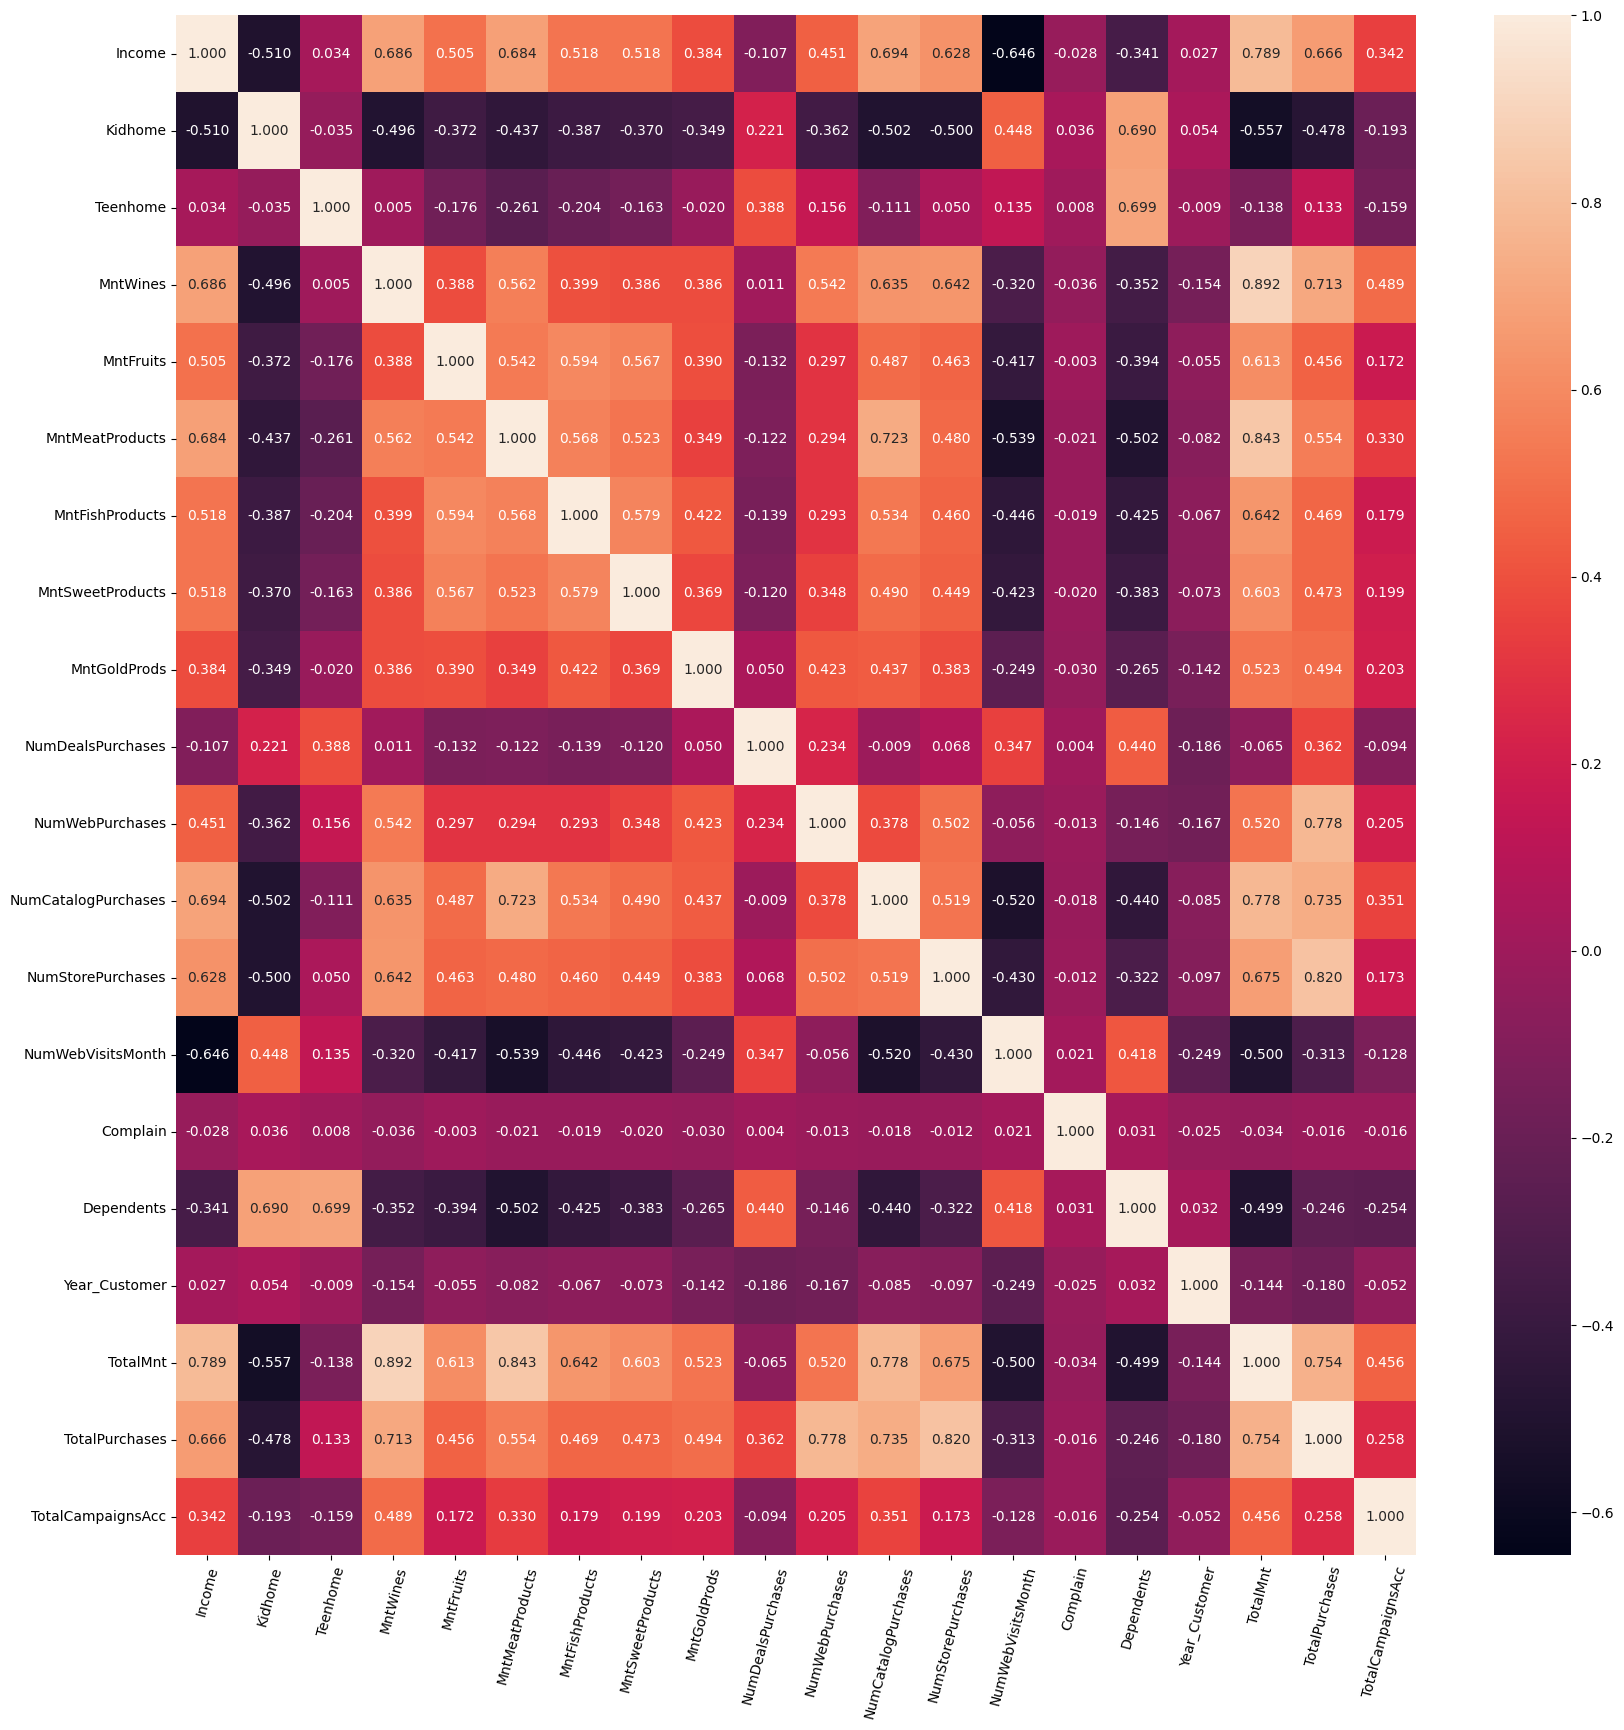

In [12]:
plt.figure(figsize=(20, 20))
sns.heatmap(
    df.drop(["ID", "Year_Birth", "Education", "Marital_Status", "Country", "Recency"] + campaign_cols, axis=1).corr(),
    annot=True,
    fmt=".3f"
)
plt.xticks(rotation=75)
plt.show()

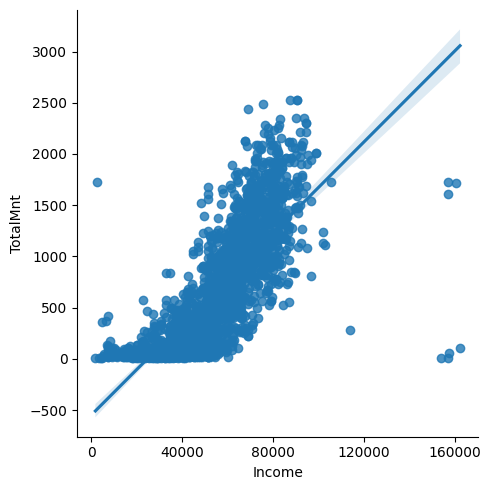

In [13]:
# Plot illustrating the effect of high income on spending

sns.lmplot(
    data=df,
    x="Income",
    y="TotalMnt"
)
plt.xticks(range(0, 160001, 40000))
plt.show()

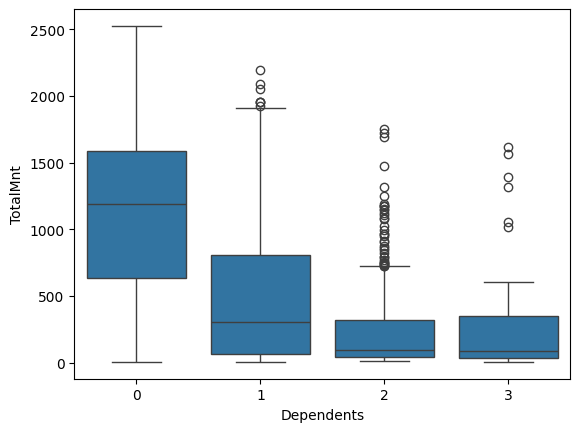

In [14]:
# Plot illustrating negative effect of having dependents on spending

sns.boxplot(
    data=df,
    x="Dependents",
    y="TotalMnt"
)
plt.show()

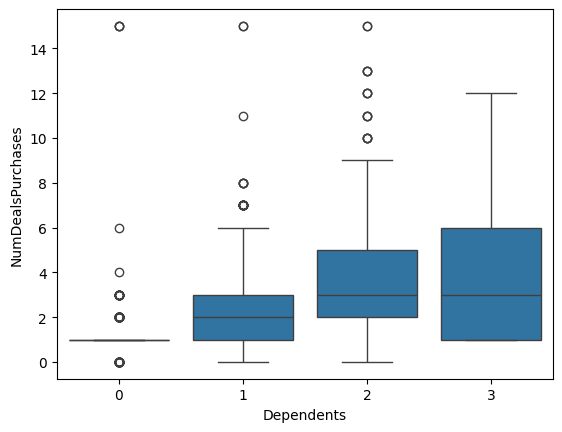

In [15]:
# Plot illustrating positive effect on having dependents on number of deals purchased

sns.boxplot(
    data=df,
    x="Dependents",
    y="NumDealsPurchases"
)
plt.show()

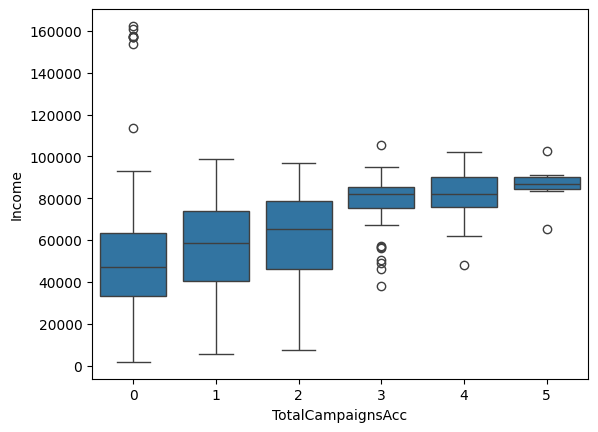

In [16]:
# Plot illustrating the positive effect of income on advertising campaign acceptance

sns.boxplot(
    data=df,
    x="TotalCampaignsAcc",
    y="Income"
)
plt.show()

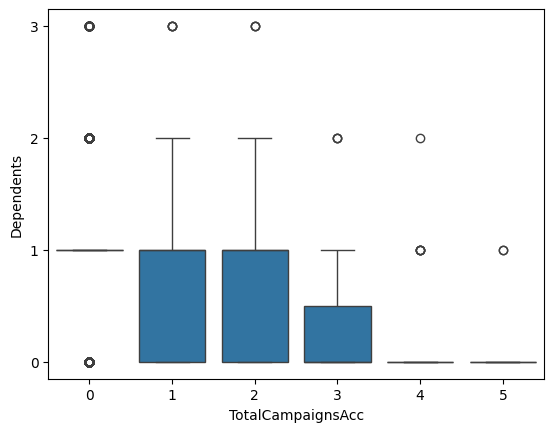

In [17]:
# Plot illustrating the negative effect of having dependents on advertising campaign acceptance

sns.boxplot(
    data=df,
    x="TotalCampaignsAcc",
    y="Dependents"
)
plt.yticks(np.arange(0, 4, 1))
plt.show()

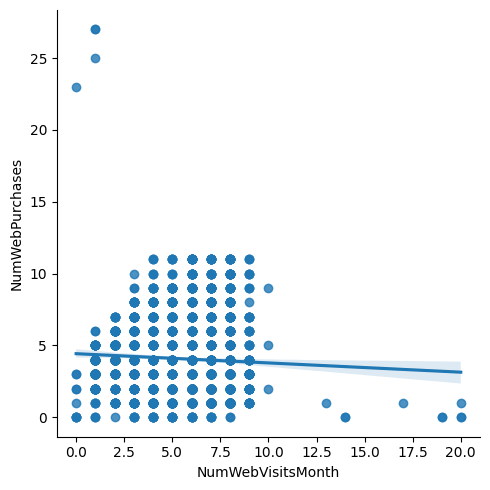

In [18]:
# Number of web visits in the last month is not positively correlated with number of web purchases

sns.lmplot(
    data=df,
    x="NumWebVisitsMonth",
    y="NumWebPurchases"
)
plt.show()

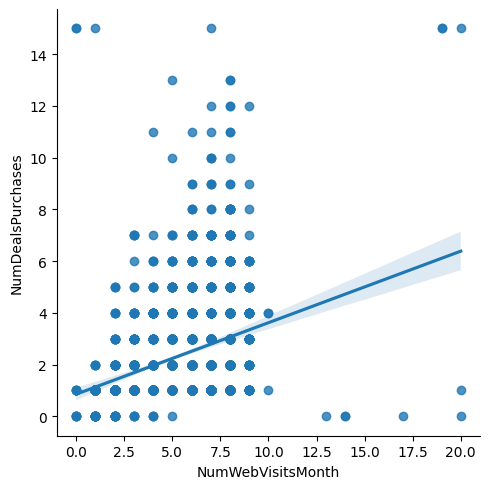

In [19]:
# Number of web visits in the last month is positively correlated with the number of deals purchased

sns.lmplot(
    data=df,
    x="NumWebVisitsMonth",
    y="NumDealsPurchases"
)
plt.show()

In [20]:
df.to_csv("data_modified.csv", index=False)